In [1]:
from scipy.stats import unitary_group
import pennylane as qml

def generate_random_circuit(num_qubits, num_cuts=1, 
                            seed_u=0, seed_v=0):
    """
    Generates a random unitary quantum circuit with specified qubits and cuts.
    
    Parameters:
    - num_qubits (int): Total number of qubits in the circuit.
    - num_cuts (int): Number of cut qubits between subcircuits.
    - seed_u (int): Seed for generating the random unitary in subcircuit AB.
    - seed_v (int): Seed for generating the random unitary in subcircuit BC.
    
    Returns:
    - qml.expval: Expectation value of the observable on the entire circuit.
    
    Raises:
    - ValueError: If the number of cuts exceeds the allowable range.
    """
    
    # Divide qubits into three sections: A, B (cut qubits), and C
    N_A_wires = num_qubits // 2
    N_B_wires = num_cuts
    N_C_wires = num_qubits - (N_A_wires + N_B_wires)
    
    # Validate the number of cuts
    if num_cuts > N_B_wires + N_C_wires or num_cuts > num_qubits:
        raise ValueError("The number of cuts exceeds the allowable range based on the circuit's qubit count.")
    
    # Define wire labels for each section
    A_wires = [f"A{x}" for x in range(N_A_wires)]
    B_wires = [f"B{x}" for x in range(N_B_wires)]
    C_wires = [f"C{x}" for x in range(N_C_wires)]
    
    # Define wire mappings for each subcircuit
    AB_wires = A_wires + B_wires  # Wires for subcircuit AB
    BC_wires = B_wires + C_wires  # Wires for subcircuit BC
    
    # Main observable (Pauli Z on each qubit)
    # observable = qml.grouping.string_to_pauli_word("Z" * num_qubits)
    observable =  qml.pauli.string_to_pauli_word("Z" * num_qubits)
    
    # Generate random unitaries for subcircuits AB and BC
    U_ab = unitary_group.rvs(2 ** len(AB_wires), random_state=seed_u)
    U_bc = unitary_group.rvs(2 ** len(BC_wires), random_state=seed_v)
    
    # Apply unitaries and wire cut
    qml.QubitUnitary(U_ab, wires=range(len(AB_wires)))
    
    qml.WireCut(wires=range(N_A_wires, N_A_wires + N_B_wires))
    
    qml.QubitUnitary(U_bc, wires=range(N_A_wires, num_qubits))
    
    # Return expectation value of the observable
    return qml.expval(observable)

/home/gideonuchehara/anaconda3/envs/ricco-cut/lib/python3.10/site-packages/pennylane/workflow/qnode.py:830: PennyLaneDeprecationWarning: The tape/qtape property is deprecated and will be removed in v0.41. Instead, use the qml.workflow.construct_tape function.
  warnings.warn(


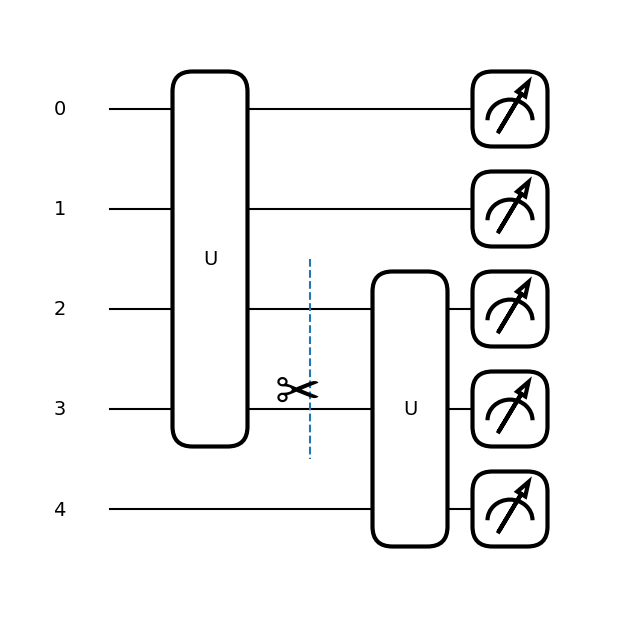

In [2]:
# from ricco.utils import (generate_random_circuit, replace_measure_with_unitary, 
#                    vqe_circuit, generate_n_qubit_unitary, ricco_string_to_pauli_word,
#                   get_upstream_subcircuit)




import pennylane as qml
from pennylane import numpy as np
num_qubits = 5
num_cuts=2
seed_u = 103
seed_v = 105

# Define RICCO parameters for unitary rotation at cut locations
# params = np.random.uniform(-np.pi, np.pi, size=4**num_cuts - 1, requires_grad=True)

# Initialize device for RICCO optimization
dev = qml.device("default.qubit", wires=range(num_qubits))

# Define and create a QNode for the generated quantum circuit
random_circuit_qnode = qml.QNode(generate_random_circuit, device=dev)

# Update QNode and Compute expectation value of the uncut circuit
uncut_random_circuit_expval = random_circuit_qnode(
    num_qubits, num_cuts, seed_u, seed_v)

# Optionally display the uncut circuit
# if draw:
fig1, ax = qml.draw_mpl(random_circuit_qnode)(num_qubits, num_cuts, 
                                              seed_u, seed_v)

tape = random_circuit_qnode.qtape
# tape.operations


In [3]:
import pennylane as qml
from pennylane.tape import QuantumTape
from pennylane.qcut import (
    MeasureNode, PrepareNode, _prep_zero_state, _prep_one_state, _get_measurements
)
from pennylane import numpy as np
from typing import Dict, List, Tuple
from itertools import product
from ricco.postprocessing import ricco_processing_fn


class RICCO:
    """
    Rotation-Inspired Circuit Cut Optimization (RICCO) Algorithm.

    This class partitions a quantum circuit into fragments, applies circuit cutting, 
    optimizes unitary rotations replacing MeasureNodes, and updates PrepareNodes 
    with their conjugate transposes.

    Attributes:
        circuit (qml.QNode): Original uncut quantum circuit.
        cuts (int): Number of wire cuts (equivalent to MeasureNodes).
        device (qml.Device): Quantum device for execution.
        num_qubits (int): Number of qubits in the circuit.
        params (List[np.ndarray]): Rotation parameters for each MeasureNode.
        tape (qml.tape.QuantumTape): Quantum tape representation of the circuit.
        tape_fragments (List[qml.tape.QuantumTape]): Partitioned circuit fragments.
        communication_graph (networkx.DiGraph): Graph representing circuit fragments.
        prep_to_meas_map (Dict[int, int]): Mapping from PrepareNode IDs to MeasureNode IDs.
        meas_to_prep_map (Dict[int, int]): Reverse mapping from MeasureNode to PrepareNode.
        meas_to_params_map (Dict[int, np.ndarray]): Mapping from MeasureNode IDs to rotation parameters.
        expanded_tapes (List[qml.tape.QuantumTape]): All expanded subcircuits.
        upstream_subcircuits (List[qml.tape.QuantumTape]): Subcircuits containing only MeasureNodes.
        midstream_subcircuits (List[qml.tape.QuantumTape]): Subcircuits containing both MeasureNodes and PrepareNodes.
        downstream_subcircuits (List[qml.tape.QuantumTape]): Subcircuits containing only PrepareNodes.
    """

    def __init__(self, circuit: qml.QNode, cuts: int, device: qml.devices, entangling_layers: int=2):
        """
        Initializes the RICCO class, partitions the circuit, and prepares it for optimization.

        Args:
            circuit (qml.QNode): The quantum circuit to be optimized.
            cuts (int): The number of wire cuts (MeasureNodes).
            device (qml.Device): The quantum device for execution.
        """
        self.circuit = circuit
        self.cuts = cuts
        self.device = device
        self.tape = circuit.qtape  # Convert QNode to a quantum tape
        self.num_qubits = len(self.tape.wires)
        self.expval = None

        # Initialize the parameters of the StronglyEngtanglingLayer unitary rotation 
        self.entangling_layers = entangling_layers
        if self.cuts == 1:
            shape = qml.StronglyEntanglingLayers.shape(n_layers=1, n_wires=self.cuts)
        else:
            shape = qml.StronglyEntanglingLayers.shape(n_layers=self.entangling_layers, n_wires=self.cuts)
        # self.params = np.random.random(size=shape)
        
        self.params = np.random.uniform(-np.pi, np.pi, size=shape)


        # Convert the quantum tape to a graph representation
        self.graph = qml.qcut.tape_to_graph(self.tape)
        qml.qcut.replace_wire_cut_nodes(self.graph)  # Replace WireCut nodes

        # Generate circuit fragments and communication graph
        frags, self.communication_graph = qml.qcut.fragment_graph(self.graph)
        self.tape_fragments = [qml.qcut.graph_to_tape(f) for f in frags]

        # Create mappings between MeasureNodes and PrepareNodes
        self.prep_to_meas_map = {
            pred_edge["pair"][1].obj.id: pred_edge["pair"][0].obj.id
            for node in self.communication_graph.nodes
            for _, pred_edges in self.communication_graph.pred[node].items()
            for pred_edge in pred_edges.values()
        }
        self.meas_to_prep_map = {v: k for k, v in self.prep_to_meas_map.items()}

        # Initialize parameter mapping for unitary rotations
        self.meas_to_params_map = {meas: param for meas, param in zip(self.prep_to_meas_map.values(), self.params)}

        

        # Initialize subcircuit attributes
        self.expanded_tapes = []
        self.measure_nodes = []
        self.prepare_nodes = []
        self.upstream_subcircuits = []
        self.midstream_subcircuits = []
        self.downstream_subcircuits = []

        # Identify the cut qubits. Here we assume each MeasureNode corresponds to a cut on one wire.
        self.cut_qubits = [op.wires[0] for tape in self.tape_fragments for op in 
                           tape.operations if isinstance(op, MeasureNode)]

        # initialize upstream midstream and downstream subcircuits with their respective unexpanded tape fragments
        for tape in self.tape_fragments:
            prepare_nodes = [op for op in tape.operations if isinstance(op, PrepareNode)]
            measure_nodes = [op for op in tape.operations if isinstance(op, MeasureNode)]

            if measure_nodes and prepare_nodes:
                self.midstream_subcircuits.append(tape)
            elif measure_nodes:
                self.upstream_subcircuits.append(tape)
            else:
                self.downstream_subcircuits.append(tape)

    def reconstruct(self):
        
        self.optimize_unitary_rotations()
        self.update_and_expand_fragment_tapes()
        # Remap tape wires to align with the device wires
        self.expanded_tapes = [qml.map_wires(t, dict(zip(t.wires, self.device.wires)))[0][0] for t in self.expanded_tapes]
        
        # Execute the tapes and process results with RICCO tensor contraction
        results = qml.execute(self.expanded_tapes, self.device, gradient_fn=None)
        # print("results = ", results)
        expectation = ricco_processing_fn(
            results, self.communication_graph, self.prepare_nodes, self.measure_nodes
        )

        self.expval = expectation
        return expectation


        
    
    def update_and_expand_fragment_tapes(self):
        """
        Expands circuit fragments, applies unitary rotations to MeasureNodes, 
        and updates PrepareNodes with their conjugate transposes. 
        Creates a separate preparation tape and combines it with the expanded tape.
        """
        # List of predefined preparation settings
        PREPARE_SETTINGS = [_prep_zero_state, _prep_one_state]
    
        expanded_tapes, all_measure_nodes, all_prepare_nodes = [], [], []
        upstream, midstream, downstream = [], [], []
    
        for tape in self.tape_fragments:
            prepare_nodes = [op for op in tape.operations if isinstance(op, PrepareNode)]
            measure_nodes = [op for op in tape.operations if isinstance(op, MeasureNode)]
            wire_map = {mn.wires[0]: i for i, mn in enumerate(measure_nodes)}
    
            for prepare_settings in product(range(len(PREPARE_SETTINGS)), repeat=len(prepare_nodes)):
                for measure_group in qml.pauli.partition_pauli_group(len(measure_nodes))[0] if measure_nodes else [[""]]:
                    measurement_ops = [qml.pauli.string_to_pauli_word(measure_group, wire_map=wire_map)] if measure_nodes else []
    
                    # Create the Preparation Tape (Initialization)
                    with qml.tape.QuantumTape() as prep_tape:
                        for op in prepare_nodes:
                            prepare_fn = PREPARE_SETTINGS[prepare_settings[prepare_nodes.index(op)]]
                            prepare_fn(op.wires[0])  # Apply the preparation function
                    
                    # Create the Expanded Tape (All other operations)
                    with qml.tape.QuantumTape() as expanded_tape:
                        for op in tape.operations:
                            if isinstance(op, PrepareNode):
                                qml.adjoint(qml.StronglyEntanglingLayers)(weights=self.params, wires=self.cut_qubits)
                            elif isinstance(op, MeasureNode):
                                qml.StronglyEntanglingLayers(weights=self.params, wires=self.cut_qubits)
                            else:
                                qml.apply(op)
    
                        # Apply measurements
                        with qml.QueuingManager.stop_recording():
                            measurements = _get_measurements(measurement_ops, tape.measurements)
                        for meas in measurements:
                            qml.apply(meas)
    
                    # Manually Merge prep_tape and expanded_tape
                    with qml.tape.QuantumTape() as combined_tape:
                        for op in prep_tape.operations:  # Add preparation operations first
                            qml.apply(op)
                        for op in expanded_tape.operations:  # Add expanded tape operations next
                            qml.apply(op)
                        for meas in expanded_tape.measurements:  # Include all measurements
                            qml.apply(meas)
    
                    expanded_tapes.append(combined_tape)
    
                    # Categorize the circuit type
                    if measure_nodes and prepare_nodes:
                        midstream.append(combined_tape)
                    elif measure_nodes:
                        upstream.append(combined_tape)
                    else:
                        downstream.append(combined_tape)
    
            all_measure_nodes.append(measure_nodes)
            all_prepare_nodes.append(prepare_nodes)
    
        self.expanded_tapes, self.measure_nodes, self.prepare_nodes = expanded_tapes, all_measure_nodes, all_prepare_nodes
        self.upstream_subcircuits, self.midstream_subcircuits, self.downstream_subcircuits = upstream, midstream, downstream


    def replace_MeasureNode_with_unitary(self, subcircuit, params) -> list:
        """
        Replaces MeasureNodes on cut qubits in all upstream subcircuits with
        a unitary rotation and updates the measurements to be expectation values
        of the new observables.
    
        Args:
            params: Differentiable parameters for the unitary rotation.
    
        Returns:
            List[QuantumTape]: A list of new quantum tapes with the MeasureNodes replaced.
    
        Raises:
            ValueError: If an upstream subcircuit does not contain any MeasureNodes.
        """        
        
        if not any(isinstance(op, qml.qcut.MeasureNode) for op in subcircuit.operations):
            raise ValueError("Subcircuit does not contain any MeasureNodes.")
            
        # For clarity, create a copy named subcircuit_with_measure.
        subcircuit_with_measure = subcircuit.copy()
        
        # Generate new observables based on the original measurement observable.
        # (This assumes the upstream subcircuit has only one measurement observable.)
        obs = subcircuit_with_measure.observables[0] # extract the observables of the cut subcircuit for uncut qubits
        obs_str = qml.pauli.pauli_word_to_string(obs, wire_map=subcircuit_with_measure.wires) # assign the identity observable to the cut wire and convert to pauli strings
        obs_wires = subcircuit_with_measure.wires
        # Create a dictionary mapping each wire to its observable letter.
        obs_wires_maps = {w: p for w, p in zip(obs_wires, obs_str)}
        new_observables = [] # new sets of observables for the entire circuit including cut qubits' observables
        
        # Generate the observables of the cut qubits. They can only be in ["I", "Z"] combinations. 
        cut_qubit_observables = ["".join(t) for t in list(product(["I", "Z"], repeat=self.cuts))]
        
        for i, ob in enumerate(cut_qubit_observables):
            ob_map = {w: p for w, p in zip(self.cut_qubits, ob)} # map the cut qubit observables to their respective wires
            for key in ob_map.keys():
                obs_wires_maps[key] = ob_map[key] # update the observables of the cut qubits
            new_observables.append("".join(obs_wires_maps.values()))  
    
        # Create a new QuantumTape that will replace the MeasureNodes with a unitary.
        with QuantumTape() as new_tape:
            for op in subcircuit_with_measure.operations:
                if isinstance(op, qml.qcut.MeasureNode):
                    qml.StronglyEntanglingLayers(weights=params, wires=self.cut_qubits)
                else:
                    qml.apply(op)
            # Add new measurements based on the updated observables.
            for obs_str in new_observables:
                wire_map = {w: i for i, w in enumerate(subcircuit_with_measure.wires)}
                observable = qml.pauli.string_to_pauli_word(obs_str, wire_map=wire_map)
                qml.expval(observable)
                
        return new_tape



    # def optimize_unitary_rotations(self, tol: int = 1e-5, stepsize: float = 0.05, optimizer=None):
    #     """
    #     Optimizes unitary rotation parameters in upstream and midstream subcircuits.
    
    #     Args:
    #         stepsize (float): Learning rate for the optimizer.
    #         optimizer (qml.Optimizer, optional): Custom optimizer (default: AdamOptimizer).
    #     """
    #     if optimizer is None:
    #         optimizer = qml.AdamOptimizer(stepsize)  # Adaptive optimizer

    #     def cost_function(params):
    #         update_upstream_subcircuits = [self.replace_MeasureNode_with_unitary(subcircuit, params) for subcircuit 
    #                                        in self.upstream_subcircuits]

    #         # Compute expectation values
    #         expvals = self.execute_subcircuits(update_upstream_subcircuits)
            
    #         # Squared deviation cost function
    #         ones_matrix = np.ones_like(expvals)
    #         cost = np.sum(ones_matrix - np.square(expvals))
    #         return cost
        

    
    #     params = self.params.copy() # make a copy of the origina parameter
    #     self.params_history = []
    #     self.steps = 0
    #     init_tol = np.inf
    #     ricco_opt = qml.AdamOptimizer(stepsize=stepsize)
    #     prev_cost = np.inf
    #     self.cost_history = []
    
    #     # Optimization loop
    #     while init_tol > tol:
    #         # Perform an optimization step and compute the new cost
    #         params, new_cost = ricco_opt.step_and_cost(cost_function,  params)
    
    #         # Update convergence criteria and log values
    #         init_tol = np.abs(prev_cost - new_cost)
    #         prev_cost = new_cost
    #         self.cost_history.append(prev_cost)
    #         self.params_history.append(params)
    #         self.steps += 1
    #         print(f"cost ast step {self.steps} = ", prev_cost)

    #     self.params = params.copy()
    #     print("Optimization complete!")


    def optimize_unitary_rotations(self, steps: int = 10, stepsize: float = 0.05, optimizer=None):
        """
        Optimizes unitary rotation parameters in upstream and midstream subcircuits.
    
        Args:
            steps (int): Number of optimization steps.
            stepsize (float): Learning rate for the optimizer.
            optimizer (qml.Optimizer, optional): Custom optimizer (default: AdamOptimizer).
        """
        if optimizer is None:
            optimizer = qml.AdamOptimizer(stepsize)  # Adaptive optimizer

        def cost_function(params):
            update_upstream_subcircuits = [self.replace_MeasureNode_with_unitary(subcircuit, params) for subcircuit 
                                           in self.upstream_subcircuits]

            # Compute expectation values
            expvals = self.execute_subcircuits(update_upstream_subcircuits)
            
            # Squared deviation cost function
            ones_matrix = np.ones_like(expvals)
            cost = np.sum(ones_matrix - np.square(expvals))
            return cost
        

    
        params = self.params.copy() # make a copy of the origina parameter
        optimal_params = []
        N_steps = 0
        conv_tol = 1e-5  # Convergence tolerance for stopping criterion
        step_size = 0.5
        tol = 10
        ricco_opt = qml.AdamOptimizer(stepsize=step_size)
        prev_cost = 100
        cost_history = [prev_cost]
    
        # Optimization loop
        while tol > conv_tol:
            # Perform an optimization step and compute the new cost
            params, new_cost = ricco_opt.step_and_cost(cost_function,  params)
    
            # Update convergence criteria and log values
            tol = np.abs(prev_cost - new_cost)
            prev_cost = new_cost
            cost_history.append(prev_cost)
            optimal_params.append(params)
            N_steps += 1
            print(f"cost ast step {N_steps} = ", prev_cost)

        self.params = params.copy()
        print("Optimization complete!")


    def execute_subcircuits(self, subcircuits):
        if not subcircuits:
            raise ValueError("No subcircuits provided for execution.")
        return qml.execute(subcircuits, self.device, diff_method="parameter-shift")[0]



In [4]:
import pennylane as qml
from pennylane.tape import QuantumTape
from pennylane.qcut import (
    MeasureNode, PrepareNode, _prep_zero_state, _prep_one_state, _get_measurements
)
from pennylane import numpy as np
from typing import Dict, List, Tuple
from itertools import product
from ricco.postprocessing import ricco_processing_fn


class RICCO:
    """
    Rotation-Inspired Circuit Cut Optimization (RICCO) Algorithm.

    This class partitions a quantum circuit into fragments, applies circuit cutting, 
    optimizes unitary rotations replacing MeasureNodes, and updates PrepareNodes 
    with their conjugate transposes.

    Attributes:
        circuit (qml.QNode): Original uncut quantum circuit.
        cuts (int): Number of wire cuts (equivalent to MeasureNodes).
        device (qml.Device): Quantum device for execution.
        num_qubits (int): Number of qubits in the circuit.
        params (List[np.ndarray]): Rotation parameters for each MeasureNode.
        tape (qml.tape.QuantumTape): Quantum tape representation of the circuit.
        tape_fragments (List[qml.tape.QuantumTape]): Partitioned circuit fragments.
        communication_graph (networkx.DiGraph): Graph representing circuit fragments.
        prep_to_meas_map (Dict[int, int]): Mapping from PrepareNode IDs to MeasureNode IDs.
        meas_to_prep_map (Dict[int, int]): Reverse mapping from MeasureNode to PrepareNode.
        meas_to_params_map (Dict[int, np.ndarray]): Mapping from MeasureNode IDs to rotation parameters.
        expanded_tapes (List[qml.tape.QuantumTape]): All expanded subcircuits.
        upstream_subcircuits (List[qml.tape.QuantumTape]): Subcircuits containing only MeasureNodes.
        midstream_subcircuits (List[qml.tape.QuantumTape]): Subcircuits containing both MeasureNodes and PrepareNodes.
        downstream_subcircuits (List[qml.tape.QuantumTape]): Subcircuits containing only PrepareNodes.
    """

    def __init__(self, circuit: qml.QNode, cuts: int, device: qml.devices, entangling_layers: int=2):
        """
        Initializes the RICCO class, partitions the circuit, and prepares it for optimization.

        Args:
            circuit (qml.QNode): The quantum circuit to be optimized.
            cuts (int): The number of wire cuts (MeasureNodes).
            device (qml.Device): The quantum device for execution.
        """
        self.circuit = circuit
        self.cuts = cuts
        self.device = device
        self.tape = circuit.qtape  # Convert QNode to a quantum tape
        self.num_qubits = len(self.tape.wires)
        self.expval = None

        # Initialize the parameters of the StronglyEngtanglingLayer unitary rotation 
        self.entangling_layers = entangling_layers
        if self.cuts == 1:
            shape = qml.StronglyEntanglingLayers.shape(n_layers=1, n_wires=self.cuts)
        else:
            shape = qml.StronglyEntanglingLayers.shape(n_layers=self.entangling_layers, n_wires=self.cuts)
        # self.params = np.random.random(size=shape)
        
        self.params = np.random.uniform(-np.pi, np.pi, size=shape)


        # Convert the quantum tape to a graph representation
        self.graph = qml.qcut.tape_to_graph(self.tape)
        qml.qcut.replace_wire_cut_nodes(self.graph)  # Replace WireCut nodes

        # Generate circuit fragments and communication graph
        frags, self.communication_graph = qml.qcut.fragment_graph(self.graph)
        self.tape_fragments = [qml.qcut.graph_to_tape(f) for f in frags]

        # Create mappings between MeasureNodes and PrepareNodes
        self.prep_to_meas_map = {
            pred_edge["pair"][1].obj.id: pred_edge["pair"][0].obj.id
            for node in self.communication_graph.nodes
            for _, pred_edges in self.communication_graph.pred[node].items()
            for pred_edge in pred_edges.values()
        }
        self.meas_to_prep_map = {v: k for k, v in self.prep_to_meas_map.items()}

        # Initialize parameter mapping for unitary rotations
        self.meas_to_params_map = {meas: param for meas, param in zip(self.prep_to_meas_map.values(), self.params)}

        

        # Initialize subcircuit attributes
        self.expanded_tapes = []
        self.measure_nodes = []
        self.prepare_nodes = []
        self.upstream_subcircuits = []
        self.midstream_subcircuits = []
        self.downstream_subcircuits = []

        # Identify the cut qubits. Here we assume each MeasureNode corresponds to a cut on one wire.
        self.cut_qubits = [op.wires[0] for tape in self.tape_fragments for op in 
                           tape.operations if isinstance(op, MeasureNode)]

        # initialize upstream midstream and downstream subcircuits with their respective unexpanded tape fragments
        for tape in self.tape_fragments:
            prepare_nodes = [op for op in tape.operations if isinstance(op, PrepareNode)]
            measure_nodes = [op for op in tape.operations if isinstance(op, MeasureNode)]

            if measure_nodes and prepare_nodes:
                self.midstream_subcircuits.append(tape)
            elif measure_nodes:
                self.upstream_subcircuits.append(tape)
            else:
                self.downstream_subcircuits.append(tape)

    def reconstruct(self):
        
        self.optimize_unitary_rotations()
        self.update_and_expand_fragment_tapes()
        # Remap tape wires to align with the device wires
        self.expanded_tapes = [qml.map_wires(t, dict(zip(t.wires, self.device.wires)))[0][0] for t in self.expanded_tapes]
        
        # Execute the tapes and process results with RICCO tensor contraction
        results = qml.execute(self.expanded_tapes, self.device, gradient_fn=None)
        # print("results = ", results)
        expectation = ricco_processing_fn(
            results, self.communication_graph, self.prepare_nodes, self.measure_nodes
        )

        self.expval = expectation
        return expectation


        
    
    def update_and_expand_fragment_tapes(self):
        """
        Expands circuit fragments, applies unitary rotations to MeasureNodes, 
        and updates PrepareNodes with their conjugate transposes. 
        Creates a separate preparation tape and combines it with the expanded tape.
        """
        # List of predefined preparation settings
        PREPARE_SETTINGS = [_prep_zero_state, _prep_one_state]
    
        expanded_tapes, all_measure_nodes, all_prepare_nodes = [], [], []
        upstream, midstream, downstream = [], [], []
    
        for tape in self.tape_fragments:
            prepare_nodes = [op for op in tape.operations if isinstance(op, PrepareNode)]
            measure_nodes = [op for op in tape.operations if isinstance(op, MeasureNode)]
            wire_map = {mn.wires[0]: i for i, mn in enumerate(measure_nodes)}
    
            for prepare_settings in product(range(len(PREPARE_SETTINGS)), repeat=len(prepare_nodes)):
                for measure_group in qml.pauli.partition_pauli_group(len(measure_nodes))[0] if measure_nodes else [[""]]:
                    measurement_ops = [qml.pauli.string_to_pauli_word(measure_group, wire_map=wire_map)] if measure_nodes else []
    
                    # Create the Preparation Tape (Initialization)
                    with qml.tape.QuantumTape() as prep_tape:
                        for op in prepare_nodes:
                            prepare_fn = PREPARE_SETTINGS[prepare_settings[prepare_nodes.index(op)]]
                            prepare_fn(op.wires[0])  # Apply the preparation function
                    
                    # Create the Expanded Tape (All other operations)
                    with qml.tape.QuantumTape() as expanded_tape:
                        for op in tape.operations:
                            if isinstance(op, PrepareNode):
                                qml.adjoint(qml.StronglyEntanglingLayers)(weights=self.params, wires=self.cut_qubits)
                            elif isinstance(op, MeasureNode):
                                qml.StronglyEntanglingLayers(weights=self.params, wires=self.cut_qubits)
                            else:
                                qml.apply(op)
    
                        # Apply measurements
                        with qml.QueuingManager.stop_recording():
                            measurements = _get_measurements(measurement_ops, tape.measurements)
                        for meas in measurements:
                            qml.apply(meas)
    
                    # Manually Merge prep_tape and expanded_tape
                    with qml.tape.QuantumTape() as combined_tape:
                        for op in prep_tape.operations:  # Add preparation operations first
                            qml.apply(op)
                        for op in expanded_tape.operations:  # Add expanded tape operations next
                            qml.apply(op)
                        for meas in expanded_tape.measurements:  # Include all measurements
                            qml.apply(meas)
    
                    expanded_tapes.append(combined_tape)
    
                    # Categorize the circuit type
                    if measure_nodes and prepare_nodes:
                        midstream.append(combined_tape)
                    elif measure_nodes:
                        upstream.append(combined_tape)
                    else:
                        downstream.append(combined_tape)
    
            all_measure_nodes.append(measure_nodes)
            all_prepare_nodes.append(prepare_nodes)
    
        self.expanded_tapes, self.measure_nodes, self.prepare_nodes = expanded_tapes, all_measure_nodes, all_prepare_nodes
        self.upstream_subcircuits, self.midstream_subcircuits, self.downstream_subcircuits = upstream, midstream, downstream


    def replace_MeasureNode_with_unitary(self, subcircuit, params) -> list:
        """
        Replaces MeasureNodes on cut qubits in all upstream subcircuits with
        a unitary rotation and updates the measurements to be expectation values
        of the new observables.
    
        Args:
            params: Differentiable parameters for the unitary rotation.
    
        Returns:
            List[QuantumTape]: A list of new quantum tapes with the MeasureNodes replaced.
    
        Raises:
            ValueError: If an upstream subcircuit does not contain any MeasureNodes.
        """        
        
        if not any(isinstance(op, qml.qcut.MeasureNode) for op in subcircuit.operations):
            raise ValueError("Subcircuit does not contain any MeasureNodes.")
            
        # For clarity, create a copy named subcircuit_with_measure.
        subcircuit_with_measure = subcircuit.copy()
        
        # Generate new observables based on the original measurement observable.
        # (This assumes the upstream subcircuit has only one measurement observable.)
        obs = subcircuit_with_measure.observables[0] # extract the observables of the cut subcircuit for uncut qubits
        obs_str = qml.pauli.pauli_word_to_string(obs, wire_map=subcircuit_with_measure.wires) # assign the identity observable to the cut wire and convert to pauli strings
        obs_wires = subcircuit_with_measure.wires
        # Create a dictionary mapping each wire to its observable letter.
        obs_wires_maps = {w: p for w, p in zip(obs_wires, obs_str)}
        new_observables = [] # new sets of observables for the entire circuit including cut qubits' observables
        
        # Generate the observables of the cut qubits. They can only be in ["I", "Z"] combinations. 
        cut_qubit_observables = ["".join(t) for t in list(product(["I", "Z"], repeat=self.cuts))]
        
        for i, ob in enumerate(cut_qubit_observables):
            ob_map = {w: p for w, p in zip(self.cut_qubits, ob)} # map the cut qubit observables to their respective wires
            for key in ob_map.keys():
                obs_wires_maps[key] = ob_map[key] # update the observables of the cut qubits
            new_observables.append("".join(obs_wires_maps.values()))  
    
        # Create a new QuantumTape that will replace the MeasureNodes with a unitary.
        with QuantumTape() as new_tape:
            for op in subcircuit_with_measure.operations:
                if isinstance(op, qml.qcut.MeasureNode):
                    qml.StronglyEntanglingLayers(weights=params, wires=self.cut_qubits)
                else:
                    qml.apply(op)
            # Add new measurements based on the updated observables.
            for obs_str in new_observables:
                wire_map = {w: i for i, w in enumerate(subcircuit_with_measure.wires)}
                observable = qml.pauli.string_to_pauli_word(obs_str, wire_map=wire_map)
                qml.expval(observable)
                
        return new_tape



    # def optimize_unitary_rotations(self, tol: int = 1e-5, stepsize: float = 0.05, optimizer=None):
    #     """
    #     Optimizes unitary rotation parameters in upstream and midstream subcircuits.
    
    #     Args:
    #         stepsize (float): Learning rate for the optimizer.
    #         optimizer (qml.Optimizer, optional): Custom optimizer (default: AdamOptimizer).
    #     """
    #     if optimizer is None:
    #         optimizer = qml.AdamOptimizer(stepsize)  # Adaptive optimizer

    #     def cost_function(params):
    #         update_upstream_subcircuits = [self.replace_MeasureNode_with_unitary(subcircuit, params) for subcircuit 
    #                                        in self.upstream_subcircuits]

    #         # Compute expectation values
    #         expvals = self.execute_subcircuits(update_upstream_subcircuits)
            
    #         # Squared deviation cost function
    #         ones_matrix = np.ones_like(expvals)
    #         cost = np.sum(ones_matrix - np.square(expvals))
    #         return cost
        

    
    #     params = self.params.copy() # make a copy of the origina parameter
    #     self.params_history = []
    #     self.steps = 0
    #     init_tol = np.inf
    #     ricco_opt = qml.AdamOptimizer(stepsize=stepsize)
    #     prev_cost = np.inf
    #     self.cost_history = []
    
    #     # Optimization loop
    #     while init_tol > tol:
    #         # Perform an optimization step and compute the new cost
    #         params, new_cost = ricco_opt.step_and_cost(cost_function,  params)
    
    #         # Update convergence criteria and log values
    #         init_tol = np.abs(prev_cost - new_cost)
    #         prev_cost = new_cost
    #         self.cost_history.append(prev_cost)
    #         self.params_history.append(params)
    #         self.steps += 1
    #         print(f"cost ast step {self.steps} = ", prev_cost)

    #     self.params = params.copy()
    #     print("Optimization complete!")


    def optimize_unitary_rotations(self, steps: int = 10, stepsize: float = 0.05, optimizer=None):
        """
        Optimizes unitary rotation parameters in upstream and midstream subcircuits.
    
        Args:
            steps (int): Number of optimization steps.
            stepsize (float): Learning rate for the optimizer.
            optimizer (qml.Optimizer, optional): Custom optimizer (default: AdamOptimizer).
        """
        if optimizer is None:
            optimizer = qml.AdamOptimizer(stepsize)  # Adaptive optimizer

        def cost_function(params):
            update_upstream_subcircuits = [self.replace_MeasureNode_with_unitary(subcircuit, params) for subcircuit 
                                           in self.upstream_subcircuits]

            # Compute expectation values
            expvals = self.execute_subcircuits(update_upstream_subcircuits)
            
            # Squared deviation cost function
            ones_matrix = np.ones_like(expvals)
            cost = np.sum(ones_matrix - np.square(expvals))
            return cost
        

    
        params = self.params.copy() # make a copy of the origina parameter
        optimal_params = []
        N_steps = 0
        conv_tol = 1e-5  # Convergence tolerance for stopping criterion
        step_size = 0.5
        tol = 10
        ricco_opt = qml.AdamOptimizer(stepsize=step_size)
        prev_cost = 100
        cost_history = [prev_cost]
    
        # Optimization loop
        while tol > conv_tol:
            # Perform an optimization step and compute the new cost
            params, new_cost = ricco_opt.step_and_cost(cost_function,  params)
    
            # Update convergence criteria and log values
            tol = np.abs(prev_cost - new_cost)
            prev_cost = new_cost
            cost_history.append(prev_cost)
            optimal_params.append(params)
            N_steps += 1
            print(f"cost ast step {N_steps} = ", prev_cost)

        self.params = params.copy()
        print("Optimization complete!")


    def execute_subcircuits(self, subcircuits):
        if not subcircuits:
            raise ValueError("No subcircuits provided for execution.")
        return qml.execute(subcircuits, self.device, diff_method="parameter-shift")[0]



In [5]:
import pennylane as qml
from pennylane.tape import QuantumTape
from pennylane.qcut import (
    MeasureNode, PrepareNode, _prep_zero_state, _prep_one_state, _get_measurements
)
from pennylane import numpy as np
from typing import Dict, List, Tuple
from itertools import product
from ricco.postprocessing import ricco_processing_fn


class RICCO:
    """
    Rotation-Inspired Circuit Cut Optimization (RICCO) Algorithm.

    This class implements the RICCO algorithm, which partitions a quantum circuit into fragments,
    applies circuit cutting, optimizes unitary rotations replacing MeasureNodes, and updates
    PrepareNodes with their conjugate transposes. The algorithm aims to optimize the parameters
    of unitary rotations to minimize the cost function, which is derived from the expectation
    values of the circuit fragments.

    Attributes:
        circuit (qml.QNode): Original uncut quantum circuit.
        cuts (int): Number of wire cuts (equivalent to MeasureNodes).
        device (qml.Device): Quantum device for execution.
        num_qubits (int): Number of qubits in the circuit.
        params (List[np.ndarray]): Rotation parameters for each MeasureNode.
        tape (qml.tape.QuantumTape): Quantum tape representation of the circuit.
        tape_fragments (List[qml.tape.QuantumTape]): Partitioned circuit fragments.
        communication_graph (networkx.DiGraph): Graph representing circuit fragments.
        prep_to_meas_map (Dict[int, int]): Mapping from PrepareNode IDs to MeasureNode IDs.
        meas_to_prep_map (Dict[int, int]): Reverse mapping from MeasureNode to PrepareNode.
        meas_to_params_map (Dict[int, np.ndarray]): Mapping from MeasureNode IDs to rotation parameters.
        expanded_tapes (List[qml.tape.QuantumTape]): All expanded subcircuits.
        upstream_subcircuits (List[qml.tape.QuantumTape]): Subcircuits containing only MeasureNodes.
        midstream_subcircuits (List[qml.tape.QuantumTape]): Subcircuits containing both MeasureNodes and PrepareNodes.
        downstream_subcircuits (List[qml.tape.QuantumTape]): Subcircuits containing only PrepareNodes.
        total_steps (int): Total number of optimization steps taken to converge.
        parameter_history (List[np.ndarray]): History of parameter values during optimization.
        cost_history (List[float]): History of cost values during optimization.
    """

    def __init__(self, circuit: qml.QNode, cuts: int, device: qml.devices, entangling_layers: int=2, verbos=False):
        """
        Initializes the RICCO class, partitions the circuit, and prepares it for optimization.

        Args:
            circuit (qml.QNode): The quantum circuit to be optimized.
            cuts (int): The number of wire cuts (MeasureNodes).
            device (qml.Device): The quantum device for execution.
            entangling_layers (int): Number of entangling layers in the StronglyEntanglingLayers unitary.
        """
        self.circuit = circuit
        self.cuts = cuts
        self.device = device
        self.verbos = verbos
        self.tape = circuit.qtape  # Convert QNode to a quantum tape
        self.num_qubits = len(self.tape.wires)
        self.expval = None

        # Initialize the parameters of the StronglyEngtanglingLayer unitary rotation 
        self.entangling_layers = entangling_layers
        if self.cuts == 1:
            shape = qml.StronglyEntanglingLayers.shape(n_layers=1, n_wires=self.cuts)
        else:
            shape = qml.StronglyEntanglingLayers.shape(n_layers=self.entangling_layers, n_wires=self.cuts)
        self.params = np.random.uniform(-np.pi, np.pi, size=shape)

        # Convert the quantum tape to a graph representation
        self.graph = qml.qcut.tape_to_graph(self.tape)
        qml.qcut.replace_wire_cut_nodes(self.graph)  # Replace WireCut nodes

        # Generate circuit fragments and communication graph
        frags, self.communication_graph = qml.qcut.fragment_graph(self.graph)
        self.tape_fragments = [qml.qcut.graph_to_tape(f) for f in frags]

        # Create mappings between MeasureNodes and PrepareNodes
        self.prep_to_meas_map = {
            pred_edge["pair"][1].obj.id: pred_edge["pair"][0].obj.id
            for node in self.communication_graph.nodes
            for _, pred_edges in self.communication_graph.pred[node].items()
            for pred_edge in pred_edges.values()
        }
        self.meas_to_prep_map = {v: k for k, v in self.prep_to_meas_map.items()}

        # Initialize parameter mapping for unitary rotations
        self.meas_to_params_map = {meas: param for meas, param in zip(self.prep_to_meas_map.values(), self.params)}

        # Initialize subcircuit attributes
        self.expanded_tapes = []
        self.measure_nodes = []
        self.prepare_nodes = []
        self.upstream_subcircuits = []
        self.midstream_subcircuits = []
        self.downstream_subcircuits = []

        # Identify the cut qubits. Here we assume each MeasureNode corresponds to a cut on one wire.
        self.cut_qubits = [op.wires[0] for tape in self.tape_fragments for op in 
                           tape.operations if isinstance(op, MeasureNode)]

        # Initialize upstream, midstream, and downstream subcircuits with their respective unexpanded tape fragments
        for tape in self.tape_fragments:
            prepare_nodes = [op for op in tape.operations if isinstance(op, PrepareNode)]
            measure_nodes = [op for op in tape.operations if isinstance(op, MeasureNode)]

            if measure_nodes and prepare_nodes:
                self.midstream_subcircuits.append(tape)
            elif measure_nodes:
                self.upstream_subcircuits.append(tape)
            else:
                self.downstream_subcircuits.append(tape)

        # Initialize optimization tracking attributes
        self.total_steps = 0
        self.parameter_history = []
        self.cost_history = []

        # Initialize mean expectation value attribute
        self.mean_expval = None


    def run_multiple_trials(self, iterations: int = 5):
        """
        Runs the RICCO optimization multiple times and computes the average expectation value.

        Args:
            iterations (int): Number of times to run the optimization.

        Returns:
            float: The average expectation value over all iterations.
        """
        expvals = []
        for _ in range(iterations):
            # Reinitialize the RICCO instance to ensure independent trials
            ricco = RICCO(self.circuit, self.cuts, self.device, self.entangling_layers)
            output = ricco.reconstruct()
            expvals.append(output)
            print(f"Iteration {_ + 1}/{iterations}, Expectation Value: {output}")

        # Compute and store the mean expectation value
        self.mean_expval = np.array(expvals).mean()
        print(f"Mean Expectation Value over {iterations} iterations: {self.mean_expval}")
        return self.mean_expval
    

    def reconstruct(self):
        """
        Reconstructs the quantum circuit by optimizing unitary rotations, updating and expanding
        fragment tapes, and computing the final expectation value using RICCO tensor contraction.

        Returns:
            float: The expectation value of the reconstructed circuit.
        """
        self.optimize_unitary_rotations()
        self.update_and_expand_fragment_tapes()
        # Remap tape wires to align with the device wires
        self.expanded_tapes = [qml.map_wires(t, dict(zip(t.wires, self.device.wires)))[0][0] for t in self.expanded_tapes]
        
        # Execute the tapes and process results with RICCO tensor contraction
        results = qml.execute(self.expanded_tapes, self.device, gradient_fn=None)
        expectation = ricco_processing_fn(
            results, self.communication_graph, self.prepare_nodes, self.measure_nodes
        )

        self.expval = expectation
        return expectation

    def update_and_expand_fragment_tapes(self):
        """
        Expands circuit fragments, applies unitary rotations to MeasureNodes, 
        and updates PrepareNodes with their conjugate transposes. 
        Creates a separate preparation tape and combines it with the expanded tape.
        """
        # List of predefined preparation settings
        PREPARE_SETTINGS = [_prep_zero_state, _prep_one_state]
    
        expanded_tapes, all_measure_nodes, all_prepare_nodes = [], [], []
        upstream, midstream, downstream = [], [], []
    
        for tape in self.tape_fragments:
            prepare_nodes = [op for op in tape.operations if isinstance(op, PrepareNode)]
            measure_nodes = [op for op in tape.operations if isinstance(op, MeasureNode)]
            wire_map = {mn.wires[0]: i for i, mn in enumerate(measure_nodes)}
    
            for prepare_settings in product(range(len(PREPARE_SETTINGS)), repeat=len(prepare_nodes)):
                for measure_group in qml.pauli.partition_pauli_group(len(measure_nodes))[0] if measure_nodes else [[""]]:
                    measurement_ops = [qml.pauli.string_to_pauli_word(measure_group, wire_map=wire_map)] if measure_nodes else []
    
                    # Create the Preparation Tape (Initialization)
                    with qml.tape.QuantumTape() as prep_tape:
                        for op in prepare_nodes:
                            prepare_fn = PREPARE_SETTINGS[prepare_settings[prepare_nodes.index(op)]]
                            prepare_fn(op.wires[0])  # Apply the preparation function
                    
                    # Create the Expanded Tape (All other operations)
                    with qml.tape.QuantumTape() as expanded_tape:
                        for op in tape.operations:
                            if isinstance(op, PrepareNode):
                                qml.adjoint(qml.StronglyEntanglingLayers)(weights=self.params, wires=self.cut_qubits)
                            elif isinstance(op, MeasureNode):
                                qml.StronglyEntanglingLayers(weights=self.params, wires=self.cut_qubits)
                            else:
                                qml.apply(op)
    
                        # Apply measurements
                        with qml.QueuingManager.stop_recording():
                            measurements = _get_measurements(measurement_ops, tape.measurements)
                        for meas in measurements:
                            qml.apply(meas)
    
                    # Manually Merge prep_tape and expanded_tape
                    with qml.tape.QuantumTape() as combined_tape:
                        for op in prep_tape.operations:  # Add preparation operations first
                            qml.apply(op)
                        for op in expanded_tape.operations:  # Add expanded tape operations next
                            qml.apply(op)
                        for meas in expanded_tape.measurements:  # Include all measurements
                            qml.apply(meas)
    
                    expanded_tapes.append(combined_tape)
    
                    # Categorize the circuit type
                    if measure_nodes and prepare_nodes:
                        midstream.append(combined_tape)
                    elif measure_nodes:
                        upstream.append(combined_tape)
                    else:
                        downstream.append(combined_tape)
    
            all_measure_nodes.append(measure_nodes)
            all_prepare_nodes.append(prepare_nodes)
    
        self.expanded_tapes, self.measure_nodes, self.prepare_nodes = expanded_tapes, all_measure_nodes, all_prepare_nodes
        self.upstream_subcircuits, self.midstream_subcircuits, self.downstream_subcircuits = upstream, midstream, downstream

    def replace_MeasureNode_with_unitary(self, subcircuit, params) -> list:
        """
        Replaces MeasureNodes on cut qubits in all upstream subcircuits with
        a unitary rotation and updates the measurements to be expectation values
        of the new observables.
    
        Args:
            params: Differentiable parameters for the unitary rotation.
    
        Returns:
            List[QuantumTape]: A list of new quantum tapes with the MeasureNodes replaced.
    
        Raises:
            ValueError: If an upstream subcircuit does not contain any MeasureNodes.
        """        
        
        if not any(isinstance(op, qml.qcut.MeasureNode) for op in subcircuit.operations):
            raise ValueError("Subcircuit does not contain any MeasureNodes.")
            
        # For clarity, create a copy named subcircuit_with_measure.
        subcircuit_with_measure = subcircuit.copy()
        
        # Generate new observables based on the original measurement observable.
        # (This assumes the upstream subcircuit has only one measurement observable.)
        obs = subcircuit_with_measure.observables[0] # extract the observables of the cut subcircuit for uncut qubits
        obs_str = qml.pauli.pauli_word_to_string(obs, wire_map=subcircuit_with_measure.wires) # assign the identity observable to the cut wire and convert to pauli strings
        obs_wires = subcircuit_with_measure.wires
        # Create a dictionary mapping each wire to its observable letter.
        obs_wires_maps = {w: p for w, p in zip(obs_wires, obs_str)}
        new_observables = [] # new sets of observables for the entire circuit including cut qubits' observables
        
        # Generate the observables of the cut qubits. They can only be in ["I", "Z"] combinations. 
        cut_qubit_observables = ["".join(t) for t in list(product(["I", "Z"], repeat=self.cuts))]
        
        for i, ob in enumerate(cut_qubit_observables):
            ob_map = {w: p for w, p in zip(self.cut_qubits, ob)} # map the cut qubit observables to their respective wires
            for key in ob_map.keys():
                obs_wires_maps[key] = ob_map[key] # update the observables of the cut qubits
            new_observables.append("".join(obs_wires_maps.values()))  
    
        # Create a new QuantumTape that will replace the MeasureNodes with a unitary.
        with QuantumTape() as new_tape:
            for op in subcircuit_with_measure.operations:
                if isinstance(op, qml.qcut.MeasureNode):
                    qml.StronglyEntanglingLayers(weights=params, wires=self.cut_qubits)
                else:
                    qml.apply(op)
            # Add new measurements based on the updated observables.
            for obs_str in new_observables:
                wire_map = {w: i for i, w in enumerate(subcircuit_with_measure.wires)}
                observable = qml.pauli.string_to_pauli_word(obs_str, wire_map=wire_map)
                qml.expval(observable)
                
        return new_tape

    def optimize_unitary_rotations(self, steps: int = 10, stepsize: float = 0.05, conv_tol: float = 1e-5, optimizer=None):
        """
        Optimizes unitary rotation parameters in upstream and midstream subcircuits.
    
        Args:
            steps (int): Number of optimization steps.
            stepsize (float): Learning rate for the optimizer.
            conv_tol (float): Convergence tolerance for stopping criterion.
            optimizer (qml.Optimizer, optional): Custom optimizer (default: AdamOptimizer).
        """
        if optimizer is None:
            # optimizer = qml.AdamOptimizer(stepsize)  # Adaptive optimizer
            optimizer = qml.GradientDescentOptimizer(stepsize)

        def cost_function(params):
            update_upstream_subcircuits = [self.replace_MeasureNode_with_unitary(subcircuit, params) for subcircuit 
                                           in self.upstream_subcircuits]

            # Compute expectation values
            expvals = self.execute_subcircuits(update_upstream_subcircuits)
            
            # Squared deviation cost function
            ones_matrix = np.ones_like(expvals)
            cost = np.sum(ones_matrix - np.square(expvals))
            # cost += 0.01 * np.sum(params**2)  # L2 regularization
            return cost
        
        params = self.params.copy() # make a copy of the original parameter
        self.parameter_history.append(params)
        tol = 10
        prev_cost = 100
        self.cost_history.append(prev_cost)
        max_steps = 500
    
        # Optimization loop
        # while tol > conv_tol:
        while tol > conv_tol and self.total_steps < max_steps:
            # Perform an optimization step and compute the new cost
            params, new_cost = optimizer.step_and_cost(cost_function,  params)
    
            # Update convergence criteria and log values
            tol = np.abs(prev_cost - new_cost)
            prev_cost = new_cost
            self.cost_history.append(prev_cost)
            self.parameter_history.append(params)
            self.total_steps += 1
            if self.verbos:
                # print(f"cost at step {self.total_steps} = ", prev_cost)
                print(f"Step {self.total_steps}, Cost: {cost}, Params: {params}")

        self.params = params.copy()
        print("Optimization complete!")

    def execute_subcircuits(self, subcircuits):
        """
        Executes the given subcircuits on the quantum device.

        Args:
            subcircuits (List[qml.tape.QuantumTape]): List of subcircuits to execute.

        Returns:
            np.ndarray: Array of expectation values from the executed subcircuits.

        Raises:
            ValueError: If no subcircuits are provided for execution.
        """
        if not subcircuits:
            raise ValueError("No subcircuits provided for execution.")
        return qml.execute(subcircuits, self.device, diff_method="parameter-shift")[0]

In [6]:
# Initialize RICCO
ricco = RICCO(random_circuit_qnode, num_cuts, dev, entangling_layers=3)

# Run multiple trials and compute the average expectation value
ricco.run_multiple_trials(iterations=1)

# Access the mean expectation value
print("Mean Expectation Value (from attribute):", ricco.mean_expval)

Optimization complete!
Iteration 1/1, Expectation Value: 0.11121247402155818
Mean Expectation Value over 1 iterations: 0.11121247402155818
Mean Expectation Value (from attribute): 0.11121247402155818


/home/gideonuchehara/anaconda3/envs/ricco-cut/lib/python3.10/site-packages/pennylane/workflow/execution.py:161: PennyLaneDeprecationWarning: gradient_fn has been renamed to diff_method in qml.execute
  warn(


In [7]:
# ricco = RICCO(random_circuit_qnode, num_cuts, dev)
# ricco.reconstruct()

In [8]:
# expval = []
# iterations = 5
# for _ in range(iterations):
#     ricco = RICCO(random_circuit_qnode, num_cuts, dev)
#     output = ricco.reconstruct()
#     expval.append(output)

# print("expval = ", np.array(expval).mean())

In [9]:
# ricco.expval

In [10]:
# expval

In [11]:
qml.execute([tape], dev)

(0.0253547545180548,)

In [12]:
ricco.update_and_expand_fragment_tapes()
for c in ricco.expanded_tapes:
    print(c.draw(show_matrices=False))
    print()

0: ─╭U(M0)─────────────────────────────────────────────────────────────┤ ╭<Z@Z@I>
1: ─├U(M0)─────────────────────────────────────────────────────────────┤ ├<Z@Z@I>
2: ─├U(M0)─╭StronglyEntanglingLayers(M1)─╭StronglyEntanglingLayers(M1)─┤ │       
3: ─╰U(M0)─╰StronglyEntanglingLayers(M1)─╰StronglyEntanglingLayers(M1)─┤ ╰<Z@Z@I>

0: ─╭U(M0)─────────────────────────────────────────────────────────────┤ ╭<Z@Z@Z>
1: ─├U(M0)─────────────────────────────────────────────────────────────┤ ├<Z@Z@Z>
2: ─├U(M0)─╭StronglyEntanglingLayers(M1)─╭StronglyEntanglingLayers(M1)─┤ ╰<Z@Z@Z>
3: ─╰U(M0)─╰StronglyEntanglingLayers(M1)─╰StronglyEntanglingLayers(M1)─┤         

0: ─╭U(M0)─────────────────────────────────────────────────────────────┤ ╭<Z@Z@Z>
1: ─├U(M0)─────────────────────────────────────────────────────────────┤ ├<Z@Z@Z>
2: ─├U(M0)─╭StronglyEntanglingLayers(M1)─╭StronglyEntanglingLayers(M1)─┤ │       
3: ─╰U(M0)─╰StronglyEntanglingLayers(M1)─╰StronglyEntanglingLayers(M1)─┤ ╰<Z@Z@Z>

0: ─╭U(M0)───